#**Installations**

In [207]:
!pip install nlpaug --no-dependencies
!pip install transformers

#**Imports**

In [90]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn import tree

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from collections import  Counter
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**Functions**

In [91]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

In [92]:
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [93]:
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [94]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [95]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [96]:
#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

#**Data**

In [168]:
df_train = pd.read_csv('transactions2.csv')
df_train.head()

,Text,Label
0,This CREDIT AGREEMENT is entered into as of No...,Preamble
1,This agreement is dated 22 December 2014 and m...,Preamble
2,This Agreement and shall be governed by and in...,Governing Law
3,The choice of South African law as the governi...,Governing Law
4,This agreement and other loan documents shall ...,Governing Law


In [169]:
test = pd.read_csv('test1.csv')
test

,Text
0,"Amendment No. 1 dated as of February 4, 2016 (..."
1,"Subject to the Legal Reservations, (a) the cho..."
2,"This Agreement, and any non-contractual obliga..."
3,Each Lender agrees to indemnify the Administra...
4,Any Lender that (a) has failed to (i) fund all...
5,This Assignment and Assumption shall be govern...
6,As soon as practicable after any payment of In...
7,"Non-Defaulting Lender means, at any time, each..."
8,Fundco Facility Agreement means the facility a...
9,Notwithstanding any provision of this Agreemen...


#***Data Augmentation***

In [170]:
import nlpaug.augmenter.word as naw

In [171]:
data = df_train.Text.values.tolist()

In [172]:
result=df_train

In [173]:
aug = naw.ContextualWordEmbsAug()
augmented_data = aug.augment(data)
df3=pd.DataFrame()
df3['Text']=augmented_data
df3['Label']=df_train['Label']
result = pd.concat([df_train,df3])

In [174]:
aug = naw.BackTranslationAug()
augmented_data = aug.augment(data)
df3=pd.DataFrame()
df3['Text']=augmented_data
df3['Label']=df_train['Label']
result = pd.concat([result,df3])


In [175]:
aug = naw.SynonymAug()
augmented_data = aug.augment(data)
df3=pd.DataFrame()
df3['Text']=augmented_data
df3['Label']=df_train['Label']
result = pd.concat([result,df3])


In [176]:
df_train=result

#**Exploratory Data Analysis**

In [177]:
print(df_train['Text'].apply(lambda x: len(str(x).split())).max())
df_train['Text'].apply(lambda x: len(str(x).split())).min()

90


12

Indemnification      24
Preamble             20
Governing Law        20
Lender Defaulting    20
Other                20
Name: Label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


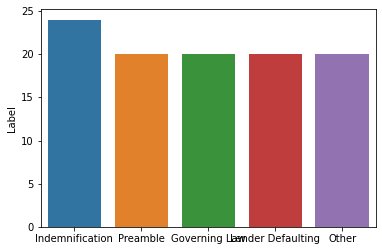

In [178]:
x=df_train['Label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [179]:
#1. WORD-COUNT
df_train['word_count'] = df_train['Text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['Label']=='Indemnification']['word_count'].mean()) 
print(df_train[df_train['Label']=='Lender Defaulting']['word_count'].mean()) 
print(df_train[df_train['Label']=='Preamble']['word_count'].mean())
print(df_train[df_train['Label']=='Governing Law']['word_count'].mean())
print(df_train[df_train['Label']=='Other']['word_count'].mean())
#Preamble is most wordy

#2. CHARACTER-COUNT
print("\n")
df_train['char_count'] = df_train['Text'].apply(lambda x: len(str(x)))
print(df_train[df_train['Label']=='Indemnification']['char_count'].mean()) 
print(df_train[df_train['Label']=='Lender Defaulting']['char_count'].mean()) 
print(df_train[df_train['Label']=='Preamble']['char_count'].mean())
print(df_train[df_train['Label']=='Governing Law']['char_count'].mean())
print(df_train[df_train['Label']=='Other']['char_count'].mean())

#3. UNIQUE WORD-COUNT
print("\n")
df_train['unique_word_count'] = df_train['Text'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['Label']=='Indemnification']['unique_word_count'].mean()) 
print(df_train[df_train['Label']=='Lender Defaulting']['unique_word_count'].mean()) 
print(df_train[df_train['Label']=='Preamble']['unique_word_count'].mean())
print(df_train[df_train['Label']=='Governing Law']['unique_word_count'].mean())
print(df_train[df_train['Label']=='Other']['unique_word_count'].mean())

30.333333333333332
32.4
52.85
41.05
41.65


199.16666666666666
198.95
321.85
243.1
254.15


26.166666666666668
28.8
42.4
28.85
32.15


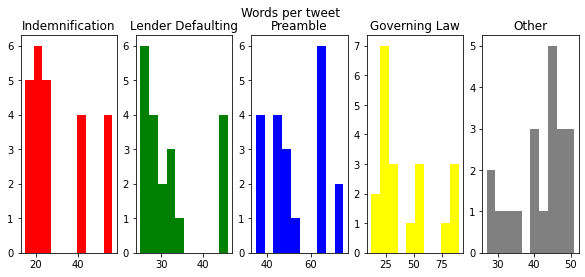

In [180]:
fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(10,4))
train_words=df_train[df_train['Label']=='Indemnification']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Indemnification')

train_words=df_train[df_train['Label']=='Lender Defaulting']['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Lender Defaulting')

train_words=df_train[df_train['Label']=='Preamble']['word_count']
ax3.hist(train_words,color='blue')
ax3.set_title('Preamble')

train_words=df_train[df_train['Label']=='Governing Law']['word_count']
ax4.hist(train_words,color='yellow')
ax4.set_title('Governing Law')

train_words=df_train[df_train['Label']=='Other']['word_count']
ax5.hist(train_words,color='grey')
ax5.set_title('Other')

fig.suptitle('Words per tweet')
plt.show()

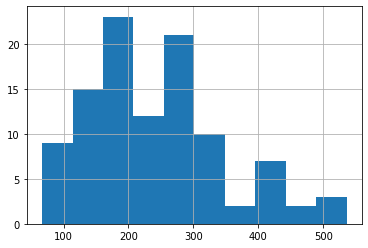

In [181]:
text=df_train['Text']
def plot_avg_sentence_length_histogram(text):
    text.str.len().hist()
plot_avg_sentence_length_histogram(text)

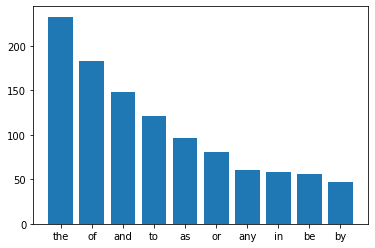

In [182]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
plot_top_stopwords_barchart(text)

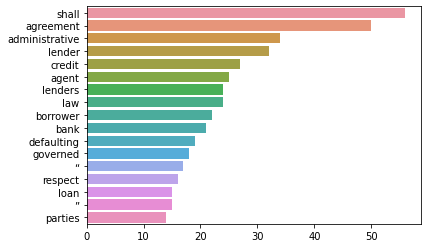

In [183]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
plot_top_non_stopwords_barchart(text.str.lower())

In [184]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

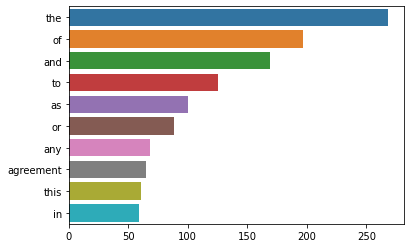

In [185]:
plot_top_ngrams_barchart(text,1)

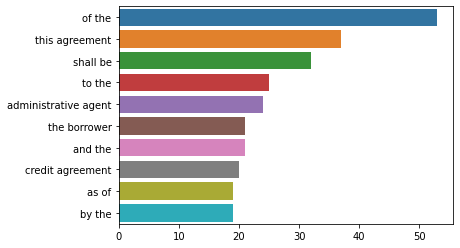

In [186]:
plot_top_ngrams_barchart(text,2)

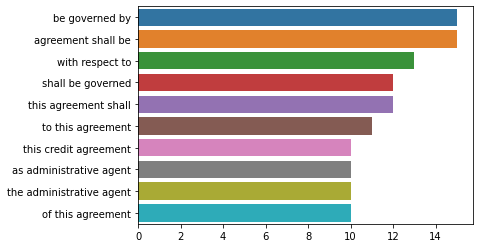

In [187]:
plot_top_ngrams_barchart(text,3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


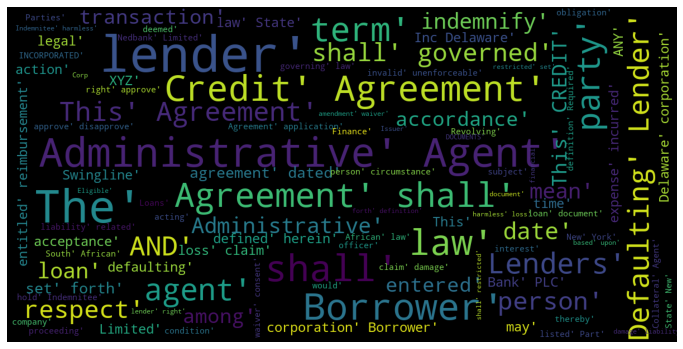

In [188]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()
plot_wordcloud(text)

In [189]:
def plot_parts_of_speech_barchart(text):
    nltk.download('averaged_perceptron_tagger')

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(7))))
    
    sns.barplot(x=y,y=x)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


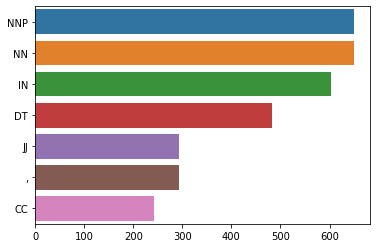

In [190]:
plot_parts_of_speech_barchart(text)

In [191]:
def plot_most_common_part_of_speech_barchart(text, part_of_speach='NN'):
    nltk.download('averaged_perceptron_tagger')
    
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type


    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(7))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


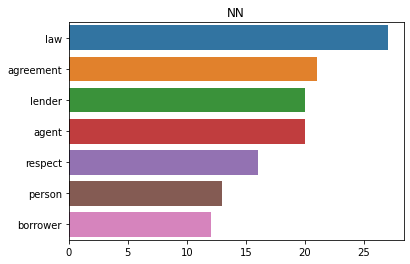

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


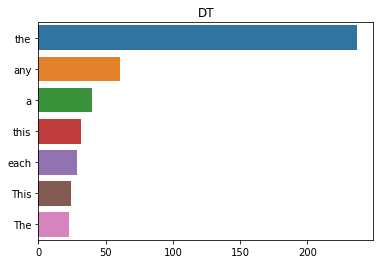

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


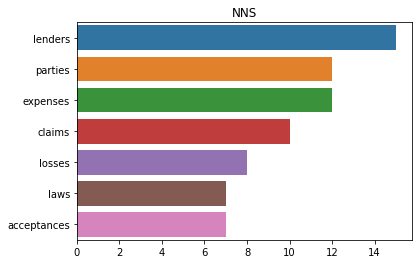

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


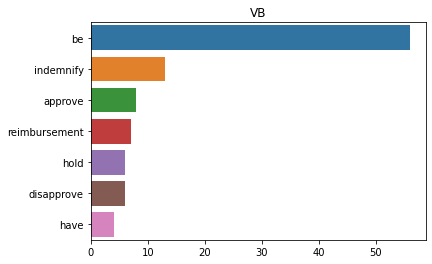

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


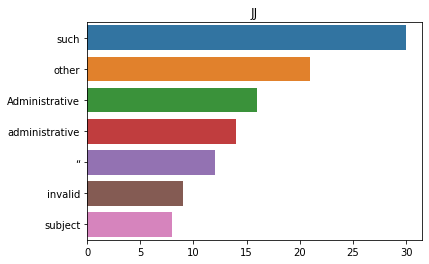

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


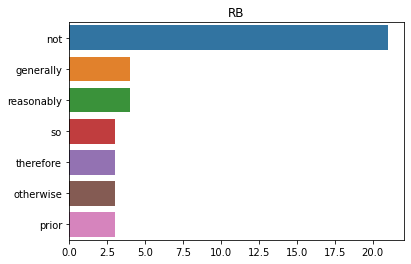

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


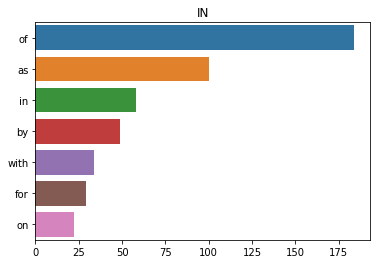

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


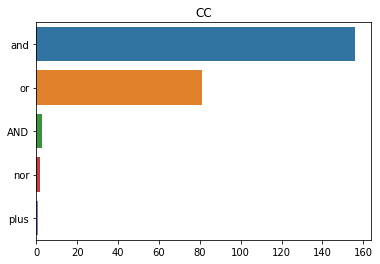

In [192]:
PARTS_OF_SPEECH = [
    "NN",
    "DT",
    "NNS",
    "VB",
    "JJ",
    "RB",
    "IN",
    "CC",
]

for part_of_speech in PARTS_OF_SPEECH:
    try:
        fig = plt.figure()
        plot_most_common_part_of_speech_barchart(text, part_of_speech)
        plt.show()
    except Exception:
        pass

In [193]:
df_train['clean_text'] = df_train['Text'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'],axis=1)
df_train.head()

,Text,Label,clean_text
0,This CREDIT AGREEMENT is entered into as of No...,Preamble,credit agreement enter november among dkin fin...
1,This agreement is dated 22 December 2014 and m...,Preamble,agreement date december make party xyz gold mi...
2,This Agreement and shall be governed by and in...,Governing Law,agreement shall govern interpreted accordance ...
3,The choice of South African law as the governi...,Governing Law,choice south african law govern law finance do...
4,This agreement and other loan documents shall ...,Governing Law,agreement loan document shall govern adherence...


#***Model Fitting***

Random Forest

In [194]:
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["Label"],
                                                  test_size=0.1,
                                                  shuffle=True)

In [195]:
vect = CountVectorizer()
tfidf=TfidfTransformer()
clf= RandomForestClassifier()
X_train_counts = vect.fit_transform(X_train.astype('U'))
X_train_tfidf = tfidf.fit_transform(X_train_counts)
clf.fit(X_train_tfidf,y_train)
X_val_counts = vect.transform(X_val.astype('U'))
X_val_tfidf= tfidf.transform(X_val_counts)
y_pred=clf.predict(X_val_tfidf)
labels = np.unique(y_pred)
confusion_mat = confusion_matrix(y_val, y_pred, labels=labels)
accuracy = (y_pred == y_val).mean()

print("Labels:", labels)
print("Confusion Matrix:\n", confusion_mat)
print("Accuracy:", accuracy)
print("Kappa score",cohen_kappa_score(y_val, y_pred))

Labels: ['Indemnification' 'Lender Defaulting' 'Other' 'Preamble']
Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]
Accuracy: 1.0
Kappa score 1.0


In [196]:
test['clean_text'] = test['Text'].apply(lambda x: finalpreprocess(x))

In [197]:
X_test = test['clean_text']

In [198]:
X_test_counts = vect.transform(X_test.astype('U'))
X_test_tfidf= tfidf.transform(X_test_counts)
y_pred=clf.predict(X_test_tfidf)
print(y_pred)

['Preamble' 'Governing Law' 'Governing Law' 'Indemnification'
 'Indemnification' 'Governing Law' 'Indemnification' 'Lender Defaulting'
 'Other' 'Lender Defaulting']


In [199]:
result = pd.DataFrame()
result['Pred']=y_pred

In [200]:
result.to_csv('final_pred.csv')

In [201]:
vect = CountVectorizer()
tfidf=TfidfTransformer()
clf= LinearSVC()
X_train_counts = vect.fit_transform(X_train.astype('U'))
X_train_tfidf = tfidf.fit_transform(X_train_counts)
clf.fit(X_train_tfidf,y_train)
X_train_tfidf.shape
X_test_counts = vect.transform(X_val.astype('U'))
X_test_tfidf= tfidf.transform(X_test_counts)
y_pred=clf.predict(X_test_tfidf)
labels = np.unique(y_pred)
confusion_mat = confusion_matrix(y_val, y_pred, labels=labels)
accuracy = (y_pred == y_val).mean()

print("Labels:", labels)
print("Confusion Matrix:\n", confusion_mat)
print("Accuracy:", accuracy)
print("Kappa score",cohen_kappa_score(y_val, y_pred))

Labels: ['Indemnification' 'Lender Defaulting' 'Other' 'Preamble']
Confusion Matrix:
 [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]
Accuracy: 1.0
Kappa score 1.0


In [202]:
# X_test_counts = vect.transform(X_test.astype('U'))
# X_test_tfidf= tfidf.transform(X_test_counts)
# y_pred=clf.predict(X_test_tfidf)
# print(y_pred)

#***Further Scope***




In [203]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [204]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [205]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

                   precision    recall  f1-score   support

  Indemnification       1.00      1.00      1.00         2
Lender Defaulting       1.00      1.00      1.00         4
            Other       1.00      1.00      1.00         3
         Preamble       1.00      1.00      1.00         2

         accuracy                           1.00        11
        macro avg       1.00      1.00      1.00        11
     weighted avg       1.00      1.00      1.00        11

Confusion Matrix: [[2 0 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [0 0 0 2]]
